<a href="https://colab.research.google.com/github/daichi-a/PythonDataAnalyzeClassMaterial/blob/master/Q_LearningSample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

状態が常に同じで報酬が変化しない場合（状態が1つしかない）場合は，Qテーブルを使わなくてもいける

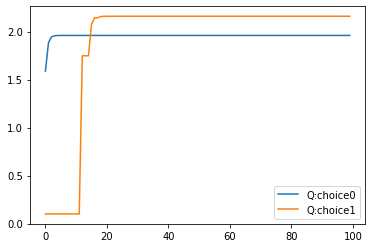

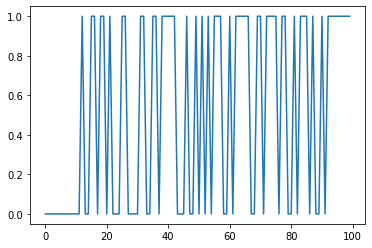

In [36]:
import numpy as np
import random
import math

num_of_trial = 100
num_of_choice = 2

# 現在のQ値を保持する．状態は常に同じ選択肢は常に同じものが2
Q = np.zeros((num_of_choice), dtype=np.float)

# 最尤推定のために選択肢を記録する
choice_array = np.zeros((num_of_trial), dtype=np.int)

# グラフの描画のために過去のQ値の変遷を100試行分格納する配列
Qpast = np.zeros((num_of_trial, num_of_choice), dtype=np.float)

#Qの初期値．両方とも同じに設定する
Q[0] = 0.1
Q[1] = 0.1

Qpast[0][0] = Q[0]
Qpast[0][1] = Q[1]

# その時点での選択確率を記録する配列
Qp = np.zeros((num_of_trial, num_of_choice), dtype=np.float)

# 報酬は，選択肢0の時は常に1.0, 選択肢1の時は常に1.2
rewards = np.array([1.0, 1.2], dtype=np.float)

# 学習率アルファ
learning_rate = 0.8

# 減衰割引率ガンマ
decay_discount_factor = 0.8

# 選択方法
choice_algorithm = 'Softmax'

for t in range(0, num_of_trial, 1):
  # 現在の試行回数がtに入る
  if choice_algorithm == 'Roulette':
    # ルーレット方式で選択肢を決定する　（一般的にはε-グリーディ法を使うので，ちょっと違うが，わかりやすくするため）
    # 現在のQ値のルーレットを作成
    sumQ = np.sum(Q)
    roulette_number = random.random() * sumQ
    if roulette_number < Q[0]:
      current_choice = 0
    else:
      current_choice = 1
  else:
    # Softmaxで行動を選択する
    p_choice_sm = np.zeros((num_of_choice), dtype=np.float)
    deno = 0.0
    for i in range(num_of_choice):
      # Softmaxの分母部分の計算
      deno += math.exp(inverse_temperature * Q[i])
    for i in range(num_of_choice): # 現在の状態において2つの選択を取る確率をそれぞれ計算
      Qp[t][i] = p_choice_sm[i] = math.exp(inverse_temperature * Q[i]) / deno


    # 乱数を振ってどの選択か決める
    softmax_num = random.random()
    current_choice = num_of_choice - 1
    sum_p = 0.0
    for i in range(num_of_choice-1):
      sum_p += p_choice_sm[i]
      if softmax_num < sum_p:
        current_choice = i
        break

    if current_choice == 0:
      # 選択肢0が選ばれた
      current_rewards = rewards[0]
      # この計算では状態によって報酬は変わらないとしているので，次の状態の報酬の最大値は常に選択肢1の報酬になる
      nextQ0 = Q[0] + learning_rate * (current_rewards + decay_discount_factor * rewards[1] - Q[0])
      # 選択肢0のQ値を更新
      Qpast[t][0] = Q[0] = nextQ0
      # 選択肢1のQ値は変わらない
      Qpast[t][1] = Q[1]

    else:
      # 選択肢1が選ばれた
      current_rewards = rewards[1]
      # この計算では状態によって報酬は変わらないとしているので，次の状態の報酬の最大値は常に選択肢1の報酬になる
      nextQ1 = Q[1] + learning_rate * (current_rewards + decay_discount_factor * rewards[1] - Q[1])
      # 選択肢1のQ値を更新
      Qpast[t][1] = Q[1] = nextQ1
      # 選択肢0のQ値は変わらない
      Qpast[t][0] = Q[0]

  choice_array[t] = current_choice

import matplotlib.pyplot as plt
x_array = np.array([range(0, num_of_trial, 1)]).ravel()
# 描画のために選択肢0と1の系列を引っ張り出すため，transposeで次元をひっくり返す
Qpast = Qpast.transpose()
plt.plot(x_array, Qpast[0].ravel(), label='Q:choice0')
plt.plot(x_array, Qpast[1].ravel(), label='Q:choice1')

plt.legend()
plt.show()
# あっという間に収束する


plt.plot(x_array, choice_array, label='Choice')
plt.show()

こいつの学習率と割引率のパラメータを、最尤推定で推定してみる

In [37]:
t_array = x_array
Q0array = Qpast[0].ravel()
Q1array = Qpast[1].ravel()
print(rewards)
#求める式 Q[t+1] = Q[t] + learning_rate α * (current_rewards + discount_factor β * max(rewards) - Q[t])
# この式のαとβを，それぞれQ0arrayとQ1arrayから求める

# https://mathtrain.jp/mle

[1.  1.2]


Q学習の対数尤度は，
$\sum_{t=1}^{T} log P(a_{t}) $
で表される．

この時，$P(a_{t})$は，各試行の実際の選択$a_t$の選択確率であり，Softmax関数を使う場合はSoftmax関数そのままの値となる．
Softmax関数は，確率を出してくれるので合計1である．素晴らしい！

Rouletteの場合は，合計1にするように計算したrouletteの数値を記録しておく．

E-Greedyは0~1で発生させた乱数が$\epsilon$以下の時，選択肢がランダムに選ばれるので，
Q値が小さい方の選択肢が$\epsilon \times 0.5$,
Q値が大きい方の選択肢が$1-\epsilon\times 0.5$ となる（はず)

対数尤度を最大化するのが最尤推定なので，対数尤度の式でそのままいける


In [39]:
# まず普通に上記のαとβを与えたものの系列から，対数尤度を求めてみる
# Softmax関数を行動選択に使った時の対数尤度関数は，Softmax関数そのままなので，
def log_likelifood_softmax(q_array):
  log_sum = 0.0
  for t in range(num_of_trial):
    log_sum += math.log(q_array[t])
  return log_sum

choice0_array = Qp.transpose()[0]
choice1_array = Qp.transpose()[1]

print(log_likelifood_softmax(choice0_array))
print(log_likelifood_softmax(choice1_array))

-71.25769187245366
-77.06924810882644


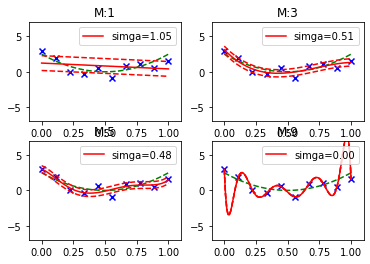

In [1]:
# http://palloc.hateblo.jp/entry/2016/01/17/231245
# を参照

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame
from numpy.random import normal

N=0 #学習用のデータ数
M=[0,0,0,0] #多項式の次数

#元の多項式
def h(t):
    y = 10 * (x - 0.5) ** 2
    return y

#データセットを作成
def create_data(num):
    dataset = DataFrame(columns=['x', 'y'])
    for i in range(num):
        x = float(i) / float(num-1) #0~1の間をデータ数で区切る
        y = h(x) + normal(scale=0.7) #正規分布の標準偏差0.7の乱数に従った雑音を付加
        dataset = dataset.append(Series([x,y], index=['x', 'y']), ignore_index=True)
    return dataset

#最尤推定でパラメータを出す
def M_l_estimation(dataset, m):
    t = dataset.y
    phi = DataFrame()
    #Φ行列を作成
    for i in range(0, m+1):
        p = dataset.x ** i
        p.name = "x ** %d" % i
        phi = pd.concat([phi, p], axis = 1)
    ws = np.dot(np.dot(np.linalg.inv(np.dot(phi.T, phi)), phi.T), t) #w=(Φ^T*Φ)^(−1)*Φ^T*tを計算

    #仮に置く多項式
    def f(x):
        y = 0.0
        for i, w in enumerate(ws):
            y += w * (x ** i)
        return y

    #s=平方平均二乗誤差(すなわち標準偏差σ)
    s = 0.0
    for index, line in dataset.iterrows():
        s += (f(line.x) - line.y) ** 2
    s /= len(dataset)

    return(f, ws, np.sqrt(s))

def main():
    # N = int(raw_input("学習用データの個数N:"))
    N = 10
    #M = [int(i) for i in (raw_input("多項式の次数M(スペース区切りで４つ入力):")).split(" ")]
    M = [1, 3, 5, 9]
    training_set = create_data(N)
    df_ws = DataFrame()
    #グラフの作成
    fig = plt.figure()
    for c, m in enumerate(M):
        f, ws, s = M_l_estimation(training_set, m)
        df_ws = df_ws.append(Series(ws, name="M=%d" % m))

                
        #subplotで複数のグラフを表示
        subplot = fig.add_subplot(2, 2, c+1)
        subplot.set_xlim(-0.1, 1.1)
        subplot.set_ylim(-7, 7)
        subplot.set_title("M:%d" % m)
        
        #元のグラフy=(x-0.5)^2を緑で表示の破線で表示
        line_x = np.linspace(0, 1, 101)
        line_y = h(line_x)
        subplot.plot(line_x, line_y, color = "green", linestyle = "--")

        #データの点を青いバツ印で表示
        subplot.scatter(training_set.x, training_set.y, marker = "x", color = "blue")

        #最尤推定で得られた多項式のグラフを表示
        line_x = np.linspace(0, 1, 101)
        line_y = f(line_x)
        label = "simga=%.2f" % s
        subplot.plot(line_x, line_y, color = "red", label = label)
        #誤差範囲の表示
        subplot.plot(line_x, line_y + s, color = "red", linestyle = "--")
        subplot.plot(line_x, line_y - s, color = "red", linestyle = "--")
        subplot.legend(loc = 1)

    fig.show()
    #raw_input("enter.")

if __name__ == '__main__':
    main()

状態が複数あり，かつ報酬が状態によって変わるので，Q-tableを使う場合

[[1.13394025 1.36613644 1.02506122]
 [1.41145615 1.43326173 1.22024845]
 [1.09589599 1.20368855 1.41071561]
 [1.10477714 1.14051966 1.37240686]]
[[2.27359767 2.45546375 0.1       ]
 [2.55650707 2.56541474 1.87052608]
 [0.1        1.90023835 2.55456834]
 [1.7821621  0.1        2.50929399]]


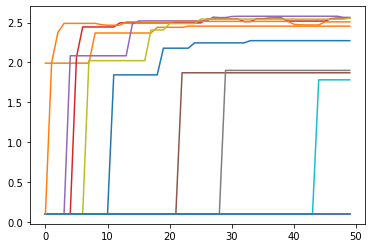

In [12]:
import numpy as np
import random

num_of_state = 4 #状態数
num_of_choice = 3 #選択肢数
num_of_trials = 50 # 試行回数

# 現在のQ値を保持するQ-table．状態数4，選択肢数3(0~3), 初期値を0.1で入れておく
# 最初の選択をするために，最初のQ値が必要となるから
Q = np.full((num_of_state, num_of_choice), 0.1, dtype=np.float)

# グラフの描画のために過去のQ値の変遷を100試行分格納する配列
# 状態数*選択肢数分保持する
Qpast = np.zeros((num_of_trials, num_of_state, num_of_choice), dtype=np.float)

# この計算では，報酬は，状態数*選択肢数の配列で，固定しておく
# つまり，選択した行動の報酬は現在の状態によって変わるが，探索中に動いたりはしない
# 1~1.5のランダムな値を入れておく
rewards = np.zeros((num_of_state, num_of_choice), dtype=np.float)
for i in range(num_of_state):
  for j in range(num_of_choice):
    rewards[i][j] = random.random() * 0.5 + 1.0
print(rewards)

# 学習率アルファ
learning_rate = 0.8

# 減衰割引率ガンマ
decay_discount_factor = 0.8

# 初期状態は，状態0とする
current_status = 0
# 100試行分の状態を記録する配列を作っておく
status_past = np.zeros((num_of_trials), dtype=np.int)
status_past[0] = current_status

# 選択アルゴリズム
# E-Greeddy, Roulette or Softmax
# ε-グリーディの，通常選択のアルゴリズム， Roulette or Softmax
choice_algorithm = 'Softmax'
# Softmaxの逆温度 1.0以上の値が入る．逆温度が大きいとSoftmaxがスレッショルドに近くなる
inverse_temperature = 1.0

# 状態遷移テーブルを作る
# この状態の時，この選択肢が選択されたら，次の状態が決まるというやつ
# これは確率にしても良いし，現在の状態とか状態の蓄積から決定木を書いても良い
# とりあえず確率にしておく
# 確率なので，1つの状態から1つの選択肢で移動する状態の確率は1.0である必要がある．
# 状態は再帰の場合もあることとする
status_transition_ratio = np.zeros((num_of_state, num_of_choice, num_of_state), dtype=np.float)

# 一つの状態で一つの選択肢からの状態遷移の総和が1.0になるように，ランダムに値を入れる
for i in range(num_of_state):
  for j in range(num_of_choice):
    s_array = np.zeros((num_of_state), dtype=np.float)
    for k in range(num_of_state):
      s_array[k] = random.random()
    for k in range(num_of_state):
      status_transition_ratio[i][j][k] = 1.0 / np.sum(s_array) * s_array[k]

# 状態遷移確率テーブルの出力
#for i in range(num_of_state):
#  print(status_transition_ratio[i])

# 終端状態が存在する場合は，初期状態に戻ることを確率として書いておけば良い

for t in range(0, num_of_trials, 1):
  # 現在の試行回数がtに入る
  
  if choice_algorithm == 'E-Greedy':
    # ε-グリーディ法で行動を選択する

    # ある適当な定数を用意（ε = 0.3）
    # 行動選択の際、0~1の間の乱数を生成し、その値がε以下であればランダムに行動を選択する
    # εより大きければQ値の大きい行動を選択する(ルーレット選択かSoftmax)ようにする
    epsilon = 0.3
    if random.random() < epsilon:
      current_choice = random.randint(0, num_of_choice-1)
      # randint(a, b)は a <= x <= bであることに注意
    else:
      # 0~1乱数がEpsilonより大きい時は，現在の一番Q値が大きい選択肢を選ぶ
      current_choice = np.argmax(Q[current_status])

  elif choice_algorithm == 'Roulette':
    # ルーレットで行動を選択する
    # 現在の状態におけるQ値の各選択肢のルーレットを作成
    sumQ = np.sum(Q[current_status])
    roulette_number = random.random() * sumQ

    # 選択肢の決定
    current_choice = num_of_choice -1
    sum_p = 0.0
    for i in range(num_of_choice -1):
      sum_p += Q[current_status][i]
      if roulette_number < sum_p:
        current_choice = i
        break
  else:
    # Softmaxで行動を選択する
    p_choice_sm = np.zeros((num_of_choice), dtype=np.float)
    deno = 0.0
    for i in range(num_of_choice):
      # Softmaxの分母部分の計算
      deno += math.exp(inverse_temperature * Q[current_status][i])
    for i in range(num_of_choice): # 現在の状態において3つの選択を取る確率をそれぞれ計算
      p_choice_sm[i] = math.exp(inverse_temperature * Q[current_status][i]) / deno
    # 乱数を振ってどの選択か決める
    softmax_num = random.random()
    current_choice = num_of_choice - 1
    sum_p = 0.0
    for i in range(num_of_choice-1):
      sum_p += p_choice_sm[i]
      if softmax_num < sum_p:
        current_choice = i
        break

  # 選択肢による報酬の決定
  current_rewards = rewards[current_status][current_choice]
  # 次の状態を状態遷移確率テーブルから選ぶ

  transition_ratio_in_current_status = status_transition_ratio[current_status][current_choice]
  sum_transition_ratio = np.sum(transition_ratio_in_current_status)
  roulette_number = random.random() * sum_transition_ratio
  sum_p = 0.0
  next_status = num_of_state - 1
  for i in range(num_of_state-1):
    sum_p += transition_ratio_in_current_status[i]
    if roulette_number < sum_p:
      next_status = i
      break

  # 次の状態での報酬の最大値を決定する
  max_next_step_rewards = np.max(rewards[next_status])
  nextQ = Q[current_status][current_choice] + learning_rate * (current_rewards + decay_discount_factor * max_next_step_rewards - Q[current_status][current_choice])

  # Q-tableを更新
  Q[current_status][current_choice] = nextQ

  # Q値の変遷を記録
  for i in range(num_of_state):
    for j in range(num_of_choice):
      Qpast[t][i][j] = Q[i][j]
  
  # 現在の状態を置き換え
  current_status = next_status

#最終的なQ-tablewを出力
print(Q)

import matplotlib.pyplot as plt
x_array = np.array([range(0, num_of_trials, 1)]).ravel()

for i in range(num_of_state):
  for j in range(num_of_choice):
    # y軸の配列，つまり，その状態とその選択肢のQ値の変遷を取り出す
    Qpast_in_one_array = np.zeros((num_of_trials), dtype=np.float)
    for t in range(num_of_trials):
      Qpast_in_one_array[t] = Qpast[t][i][j]
    # 表示用ラベルを作る
    display_label = 'Q:' + 'status' + str(i) + ',choice' + str(j)
    plt.plot(x_array, Qpast_in_one_array, label=display_label)

# plt.legend()
plt.show()